# NQ&A Prediction

In [71]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf

from scripts import nqa_utils
from scripts.prediction_utils import grid_search_weights, print_scores
from scripts.nqa_utils import Answer, AnswerType
from scripts import bert_modeling as modeling
from scripts import bert_tokenization
from scripts import albert
from scripts import albert_tokenization
from scripts.models import build_model

import collections
from collections import OrderedDict, namedtuple
import copy
import itertools
import json
import absl
import sys
import os
import warnings

In [72]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(absl.flags.FLAGS)

flags = absl.flags

### Main Model Flags ###

flags.DEFINE_string(
    "model", "bert",
    "The name of model to use. Choose from ['bert', 'albert'].")

flags.DEFINE_string(
    "config_file", "models/bert_joint_baseline/bert_config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("vocab_file", "models/bert_joint_baseline/vocab-nq.txt",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "init_checkpoint", "models/bert_joint_baseline/tf2_bert_joint.ckpt",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer("predict_batch_size", 1,
                     "Total batch size for predictions.")

### Second Model Flags ###

flags.DEFINE_string(
    "second_model", "albert",
    "The name of model to use. Choose from ['albert', 'bert'].")

flags.DEFINE_string(
    "second_config_file", "models/albert_xxl/config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("second_vocab_file", "models/albert_xxl/vocab/modified-30k-clean.model",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "second_init_checkpoint", "models/albert_xxl/albert_finetuned_v2.h5",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "second_max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "second_batch_size", 1,
    "Batch size when running verifier predictions.")

### Other Flags ###

flags.DEFINE_string(
    "output_dir", "output/",
    "The output directory where the model checkpoints will be written.")

flags.DEFINE_string(
    "log_dir", "logs/",
    "Where logs, specifically Tensorboard logs, will be saved to.")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_predict", True, "Whether to run eval on the dev set.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_float(
    "include_unknowns", 1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

absl.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

# TODO(Edan): Look at nested contents too at some point
# Around 5% of long answers are nested, and around 50% of questions have
# long answers
# This means that this setting alone restricts us from a correct answer
# around 2.5% of the time
flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "n_examples", 1000,
    "Number of examples to read from files.")

flags.DEFINE_boolean(
    "test_post_processing", True,
    "If true, training data will be predicted for instead of eval data,"
    "and the predictions will be used to tune the post processing algorithm.")

flags.DEFINE_integer(
    "tokens_per_small_example", 105*12, # On average about 12 features
    "The amount of tokens allowed on average for an example to be considered "
    "small. Small examples are run directly through ALBERT-xxl.")

### Currently Not In Use ###

flags.DEFINE_integer(
    "max_features_per_small_example", 15,
    "The amount of features allowed for a small example before being truncated.")

flags.DEFINE_integer(
    "max_features_per_example", 65,
    "The amount of features allowed for an example before being truncated.")

flags.DEFINE_string(
    "train_file", "data/simplified-nq-dev.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")

## Special flags - do not change

flags.DEFINE_string(
    "predict_file", "data/simplified-nq-dev.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

FLAGS = flags.FLAGS
FLAGS(sys.argv) # Parse the flags

N_TRAIN_EXAMPLES = 307373

# Data Formatting

In [73]:
if FLAGS.test_post_processing:
    input_file = FLAGS.train_file
    actual_answers = nqa_utils.get_actual_answers(input_file, FLAGS.n_examples)
    raw_examples = next(nqa_utils.raw_data_generator(input_file, FLAGS.n_examples))
    raw_examples = [dict(row) for _, row in raw_examples.iterrows()]
else:
    input_file = FLAGS.predict_file
    
candidates_dict = nqa_utils.read_candidates(input_file, n=FLAGS.n_examples)

print("Predict File:", input_file)

eval_examples = nqa_utils.read_nq_examples(
      input_file=input_file, is_training=FLAGS.test_post_processing, n=FLAGS.n_examples)

id_to_example = {}
for example in eval_examples:
    id_to_example[example.example_id] = example

final_answers = {}

Predict File: data/simplified-nq-dev.jsonl


# Prediction Part 1: ALBERT Small Examples

In [74]:
small_examples = []
remaining_examples = []

n_total_tokens = 0
n_total_examples = 0
sorted_examples = sorted(eval_examples, key=lambda x: len(x.doc_tokens))
for example in sorted_examples:
    n_tokens = len(example.doc_tokens)
    n_total_tokens += n_tokens
    n_total_examples += 1
    
    if n_total_examples and n_total_tokens and \
        n_total_tokens / n_total_examples >= FLAGS.tokens_per_small_example:
        break
        
small_examples = sorted_examples[:n_total_examples]
remaining_examples = sorted_examples[n_total_examples:]
# small_examples = eval_examples

if FLAGS.second_model == 'bert':
    tokenizer_small = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
    lowercase = False
elif FLAGS.second_model == 'albert':
    tokenizer_small = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.second_vocab_file)
    lowercase = True

def append_feature_small(feature):
    eval_features_small.append(feature)
    eval_writer_small.process_feature(feature)

eval_writer_small = nqa_utils.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_small.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features_small = []

nqa_utils.convert_examples_to_features(
  examples=small_examples,
  tokenizer=tokenizer_small,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature_small,
  lowercase=lowercase)

eval_writer_small.close()
eval_filename_small = eval_writer_small.filename

print('# Small Examples:', len(small_examples))
print('# Features:', len(eval_features_small))

# Small Examples: 388
# Features: 4541


# Build Model and Run Predictions

In [75]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

In [76]:
n_steps = np.ceil(eval_writer_small.num_features / FLAGS.second_batch_size)
generator = nqa_utils.data_generator(eval_filename_small, FLAGS.second_batch_size)

preds_small = model.predict(generator, steps=n_steps)

In [242]:
# Aggressive
# weights = {
#     'ans_type_conf_weight': 0.1,
#     'start_pos_conf_weight': 0.45,
#     'end_pos_conf_weight': 0.45,
#     'conf_threshold': 0.99
# }

weights = {
    'ans_type_conf_weight': 0.4,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.2,
    'conf_threshold': 0.8
}

answers_small = nqa_utils.compute_answers(preds_small, candidates_dict,\
                                          eval_features_small, small_examples,
                                          id_to_example, weights)
final_answers.update(answers_small)

if FLAGS.test_post_processing:
    print_scores(nqa_utils.score_preds(raw_examples, answers_small))

Total Score 
 F1 = 0.661 | Recall = 0.511 | Precision = 0.935 | TP = 259 | FP = 248 | FN = 18 | TN = 251 

Long Answer Score 
 F1 = 0.677 | Recall = 0.527 | Precision = 0.946 | TP = 157 | FP = 141 | FN = 9 | TN = 81 

Short Answer Score 
 F1 = 0.637 | Recall = 0.488 | Precision = 0.919 | TP = 102 | FP = 107 | FN = 9 | TN = 170 



# Grid Search for Postprocessing Parameters

In [80]:
if True:
    weight_ranges = collections.OrderedDict({
            'ans_type_conf_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
            'start_pos_conf_weight': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6],
            'end_pos_conf_weight': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6],
            'conf_threshold': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
        })

    results = grid_search_weights(raw_examples,
                                  preds_small,
                                  candidates_dict, 
                                  eval_features_small, 
                                  small_examples, 
                                  id_to_example,
                                  weight_ranges)
    
    for result in results[:10]:
        print(result)

  1%|          | 78/11583 [00:05<30:12,  6.35it/s]/home/ejmejm/MLProjects/kaggle-nqa/scripts/nqa_utils.py:1658: UserWarning: Unexpected while parsing features: <class 'KeyboardInterrupt'>
  warnings.warn("Unexpected while parsing features: {}".format(sys.exc_info()[0]))
  2%|▏         | 178/11583 [00:19<41:46,  4.55it/s]

KeyboardInterrupt: 

# Prediction Part 2: BERT-Joint Remaining Examples

In [164]:
# remaining_examples = eval_examples

In [165]:
if FLAGS.model == 'bert':
    tokenizer = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)
elif FLAGS.model == 'albert':
    tokenizer = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.vocab_file)

eval_writer = nqa_utils.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_remaining.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features = []

def append_feature(feature):
    eval_features.append(feature)
    eval_writer.process_feature(feature)

nqa_utils.convert_examples_to_features(
  examples=remaining_examples,
  tokenizer=tokenizer,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature)
eval_writer.close()
eval_filename = eval_writer.filename

print('# Remaning Examples:', len(remaining_examples))
print('# Features:', len(eval_features))

# Remaning Examples: 612
# Features: 27233


In [166]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

# nf_map = {}
# for f in eval_features:
#     if f.example_index in nf_map:
#         nf_map[f.example_index] += 1
#     else:
#         nf_map[f.example_index] = 1

# n_tokens_to_features = []
# for example in remaining_examples:
#     n_tokens = len(example.doc_tokens)
#     n_features = nf_map[example.example_id]
#     n_tokens_to_features.append((n_tokens, n_features))

# print(pd.Series([x[0] / x[1] for x in n_tokens_to_features]).describe())

# sns.scatterplot([x[0] for x in n_tokens_to_features], [x[1] for x in n_tokens_to_features], alpha=0.4, s=60)

## Build the Model and Run Predictions

In [167]:
model = build_model(model_name=FLAGS.model,
                    config_file=FLAGS.config_file,
                    max_seq_length=FLAGS.max_seq_length,
                    init_ckpt=FLAGS.init_checkpoint)
model.summary()

Model: "bert_baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
bert (BertModel)                ((None, 1024), (None 335141888   input_ids[0][0]                  
                                                                 input_mask[0][0]     

In [168]:
n_steps = np.ceil(eval_writer.num_features / FLAGS.predict_batch_size)
generator = nqa_utils.data_generator(eval_filename, FLAGS.predict_batch_size)

preds = model.predict_generator(generator, steps=n_steps)

In [51]:
# from scipy.special import softmax
# def check_entry_in_candidates(entry):
#     """Checks if the entry start and ending tokens fall into a candidate.
#         Returns the candidate index, or -1 if none is found."""
#     if not FLAGS.skip_nested_contexts:
#         raise NotImplementedError('Nested contexts have not been implemented for predictions yet!')
#     else:
#         for cand_idx, candidate in enumerate(entry['candidates']):
#             if not candidate['top_level']:
#                 continue
#             if entry['orig_start'] >= candidate['start_token'] and \
#                 entry['orig_end'] <= candidate['end_token']:
#                 return cand_idx
#     return -1


# def get_candidate_span(entry):
#     return (entry['candidates'][entry['candidate_idx']]['start_token'],
#             entry['candidates'][entry['candidate_idx']]['end_token'])

# def compute_answers(preds, candidates_dict, features,
#                     examples, id_to_examples, weights={},
#                     invalid_input_ids=[]):
#     default_weights = {
#         'ans_type_conf_weight': 0.4,
#         'start_pos_conf_weight': 0.3,
#         'end_pos_conf_weight': 0.3,
#         'conf_threshold': 0.98
#     }
    
#     for k, v in default_weights.items():
#         if k not in weights:
#             weights[k] = v
    
#     ### Get variables needed for post processing ###
#     start_token_probs = softmax(preds[0], axis=1)
#     end_token_probs = softmax(preds[1], axis=1)
#     ans_type_probs = softmax(preds[2], axis=1)
#     candidates_dict = {int(k): v for k, v in candidates_dict.items()}

#     ### Create doc span groups ###
    
#     doc_span_groups = {}
#     for i, feature in enumerate(features):
#         example_idx = feature.example_index
#         if example_idx not in doc_span_groups:
#             doc_span_groups[example_idx] = []

#         group_data = {
#             'start_tokens_probs': start_token_probs[i],
#             'end_tokens_probs': end_token_probs[i],
#             'ans_type_probs': ans_type_probs[i],
#             'candidates': candidates_dict[example_idx],
#             'feature': features[i],
#             'doc_tokens_map': id_to_examples[example_idx].doc_tokens_map
#         }

#         doc_span_groups[example_idx].append(group_data)
    
#     ### Compute answers ###
        
#     answers = {} # Maps example_ids to long and short answers
#     for example_id, group in doc_span_groups.items():
#         example = id_to_examples[example_id]
#         example.n_features = len(group)
#         doc_to_orig = example.doc_tokens_map
        
#         assert doc_to_orig is not None
        
#         # Reverse doc_to_orig to create orig_to_doc
#         orig_to_doc = {}
#         for doc_token_idx, orig_tok_idx in enumerate(doc_to_orig):
#             orig_to_doc[orig_tok_idx] = doc_token_idx
#         orig_to_doc[-1] = -1
#         example.orig_to_doc = orig_to_doc
        
#         # This loop just gathers the non-unknown, valid predictions
#         valid_entries = []
#         for entry in group:
#             try:
#                 # Converting logits to answer values
#                 entry['start_token_idx'] = np.argmax(entry['start_tokens_probs'])
#                 entry['end_token_idx'] = np.argmax(entry['end_tokens_probs'])
#                 entry['ans_type_idx'] = np.argmax(entry['ans_type_probs'])

#                 entry['start_pos_prob'] = entry['start_tokens_probs'][entry['start_token_idx']]
#                 entry['end_pos_prob'] = entry['end_tokens_probs'][entry['end_token_idx']]
#                 entry['ans_type_prob'] = entry['ans_type_probs'][entry['ans_type_idx']]

#                 # Calculating probability of the chosen answer type
#                 entry['prob'] = entry['start_pos_prob'] * weights['start_pos_conf_weight'] + \
#                                 entry['end_pos_prob'] * weights['end_pos_conf_weight'] + \
#                                 entry['ans_type_prob'] * weights['ans_type_conf_weight']

#                 # Filter out entries with invalid answers
#                 if entry['end_token_idx'] < entry['start_token_idx'] or \
#                     (entry['end_token_idx'] - entry['start_token_idx'] > FLAGS.max_answer_length and \
#                      entry['ans_type_idx'] == AnswerType.SHORT) or \
#                     entry['feature'].segment_ids[entry['start_token_idx']] == 0 or \
#                     entry['feature'].segment_ids[entry['end_token_idx']] == 0 or \
#                     entry['feature'].input_mask[entry['start_token_idx']] == 0 or \
#                     entry['feature'].input_mask[entry['end_token_idx']] == 0 or \
#                     entry['feature'].input_ids[entry['start_token_idx']] in invalid_input_ids or \
#                     entry['feature'].input_ids[entry['end_token_idx']] in invalid_input_ids or \
#                     entry['ans_type_idx'] == AnswerType.UNKNOWN or \
#                     entry['prob'] < weights['conf_threshold']:
#                     continue
                    
#                 # Getting indices of tokens in original document
#                 tok_to_orig_map = entry['feature'].token_to_orig_map
                
#                 entry['orig_start'] = tok_to_orig_map[entry['start_token_idx']]
#                 entry['orig_end'] = tok_to_orig_map[entry['end_token_idx']] + 1

#                 entry['doc_tokens_start_idx'] = -1
#                 entry['doc_tokens_end_idx'] = -1

#                 # Getting indices of tokens in preprocessed document
#                 if entry['orig_start'] in orig_to_doc:
#                     entry['doc_tokens_start_idx'] = orig_to_doc[entry['orig_start']]
#                 else:
#                     # I'm not sure if this resolution works
# #                     print('Resolving orig_to_doc missing index, but resolution method may be flawed!')
#                     target = entry['orig_start']
#                     for key in sorted(orig_to_doc.keys()):
#                         if key > target:
#                             entry['doc_tokens_start_idx'] = orig_to_doc[key]
#                             break

#                 if entry['orig_end'] in orig_to_doc:
#                     entry['doc_tokens_end_idx'] = orig_to_doc[entry['orig_end'] - 1] + 1
#                 else:
#                     # I'm not sure if this resolution works
# #                     print('Resolving orig_to_doc missing index, but resolution method may be flawed!')
#                     target = entry['orig_end'] - 1
#                     for key in sorted(orig_to_doc.keys(), reverse=True):
#                         if key < target:
#                             entry['doc_tokens_end_idx'] = orig_to_doc[key] + 1
#                             break

#                 if entry['doc_tokens_start_idx'] == -1 or entry['doc_tokens_end_idx'] == -1 \
#                    or entry['doc_tokens_end_idx'] == 0:
#                     warnings.warn('Original to document index mapping could not be resolved!')
#                     continue

#                 entry['candidate_idx'] = check_entry_in_candidates(entry)
#                 if entry['candidate_idx'] == -1:
#                     continue

#                 valid_entries.append(entry)
#             except:
#                 warnings.warn("Unexpected while parsing features: {}".format(sys.exc_info()[0]))

#         long_answer = None
#         short_answer = None
#         doc_tokens_span = None
#         ordered_entries = None
            
#         if len(valid_entries) > 0:
#             # TODO(Edan): I think I should probably prioritize short answers
#             # over long answers because both can be right, but most long answer
#             # also have short answers
#             # I could also look at if other probabilities are also high,
#             # ideally only a single entry should have a high logit
#             # Ammend: not only one entry, but one and the ones near it
#             ordered_entries = sorted(valid_entries, key=lambda e: e['prob'], reverse=True)
#             best_entry = ordered_entries[0]
#             if best_entry['ans_type_idx'] == AnswerType.LONG:
#                 long_answer = get_candidate_span(best_entry)
#             elif best_entry['ans_type_idx'] == AnswerType.SHORT:
#                 long_answer = get_candidate_span(best_entry)
#                 short_answer = (best_entry['orig_start'], best_entry['orig_end'])
#             elif best_entry['ans_type_idx'] == AnswerType.YES:
#                 long_answer = get_candidate_span(best_entry)
#                 short_answer = 'YES'
#             elif best_entry['ans_type_idx'] == AnswerType.NO:
#                 long_answer = get_candidate_span(best_entry)
#                 short_answer = 'NO'
#             else:
#                 raise ValueError('Entry should not have AnswerType UNKNOWN or other!')
                
#             doc_tokens_start = best_entry['doc_tokens_start_idx']
#             doc_tokens_end = best_entry['doc_tokens_end_idx']
#             doc_tokens_span = (doc_tokens_start, doc_tokens_end)
        
#         answers[example_id] = {'long_answer': long_answer,
#                                'short_answer': short_answer,
#                                'doc_tokens_span': doc_tokens_span,
#                                'ordered_entries': ordered_entries}

#     return answers

# nqa_utils.compute_answers = compute_answers

In [178]:
weights = {
    'ans_type_conf_weight': 0.4,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.3,
    'conf_threshold': 0.8
}

answers = nqa_utils.compute_answers(preds, candidates_dict,
                                    eval_features, remaining_examples,
                                    id_to_example, weights)
final_answers.update(answers)

if FLAGS.test_post_processing:
    print('BERT Answers')
    print_scores(nqa_utils.score_preds(raw_examples, answers))
    print()
    print('All Answers')
    print_scores(nqa_utils.score_preds(raw_examples, final_answers))

BERT Answers
Total Score 
 F1 = 0.507 | Recall = 0.347 | Precision = 0.939 | TP = 325 | FP = 611 | FN = 21 | TN = 267 

Long Answer Score 
 F1 = 0.554 | Recall = 0.386 | Precision = 0.981 | TP = 205 | FP = 326 | FN = 4 | TN = 77 

Short Answer Score 
 F1 = 0.443 | Recall = 0.296 | Precision = 0.876 | TP = 120 | FP = 285 | FN = 17 | TN = 190 


All Answers
Total Score 
 F1 = 0.565 | Recall = 0.405 | Precision = 0.937 | TP = 584 | FP = 859 | FN = 39 | TN = 518 

Long Answer Score 
 F1 = 0.601 | Recall = 0.437 | Precision = 0.965 | TP = 362 | FP = 467 | FN = 13 | TN = 158 

Short Answer Score 
 F1 = 0.515 | Recall = 0.362 | Precision = 0.895 | TP = 222 | FP = 392 | FN = 26 | TN = 360 



In [179]:
if False:
    weight_ranges = collections.OrderedDict({
            'ans_type_conf_weight': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
            'start_pos_conf_weight': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
            'end_pos_conf_weight': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
            'conf_threshold': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
        })

    results = grid_search_weights(raw_examples,
                                  preds,
                                  candidates_dict, 
                                  eval_features, 
                                  remaining_examples, 
                                  id_to_example,
                                  weight_ranges)
    
    for result in results[:10]:
        print(result)

# Answers Data Analysis

### Things to explore (WIP)
- Can we accurately order the answers in terms of confidence?
- Is a series of segments all with answers a good predictor for an actual answer in that block?
- What does the general spread of probabilities look like when there is an answer?
- What about the spread of probabilities when there is no answer?




- If 1, 2, and 3 are in a row, choose the middle one

In [180]:
def in_range(first, second):
    return first[0] >= second[0] and first[1] <= second[1]

In [181]:
avg_n_features = 0
ordering_reg_data = [] # (predicted rank of answer, whether there actually is answer at that feature)
n_preds_data = [] # (percent of features that predict an answer, whether there is actually an answer)

for example_id in answers.keys():
    pred_answer = answers[example_id]
    actual_answer = actual_answers[example_id]
    
    if not pred_answer['ordered_entries']:
        continue
    
    avg_n_features += id_to_example[example_id].n_features
    entries_pred = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    actual_oh = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    for entry_idx, entry in enumerate(pred_answer['ordered_entries']):
        feature = entry['feature']
        entries_pred[feature.doc_span_index] = entry_idx + 1
        
        tok_to_orig_map = entry['feature'].token_to_orig_map
        feature_min_idx = min(tok_to_orig_map.values(), key=lambda x: x if x != -1 else 99999)
        feature_max_idx = max(tok_to_orig_map.values())
        target_answers = actual_answer['long_answers']
        if isinstance(actual_answer['short_answers'], tuple):
            target_answers = actual_answer['short_answers']
        if target_answers:
            for tgt in target_answers:
                if in_range(tgt, (feature_min_idx, feature_max_idx)):
                    actual_oh[feature.doc_span_index] = 1
                    break
     
    percent_preds = len(pred_answer['ordered_entries']) / id_to_example[example_id].n_features
    exists_answer = int(1 in actual_oh)
    n_preds_data.append((percent_preds, exists_answer))
    
    for x, y in zip(entries_pred, actual_oh):
        if x != 0 or y != 0:
            ordering_reg_data.append((x, y))
    
    print(entries_pred)
    print(actual_oh)
    print()

print('Avg # features per example:', avg_n_features / len(answers.keys()))

[3 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 0 12  1  2  3  8  9  0  0  7 10  6  4  0  5  0  0 11]
[0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

[2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[4 0 0 0 0 0 0 0 0 0 0 0 0 7 5 6 3 2 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]

[0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 3 5 2 0 4 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[3 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[2 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[2 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3]

[ 8  0  2  1  3  0  0  0 12  4  5  0  0  0  0  0  0  0  0  0 10  7  6  0
  0  0  0 11  9  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 5 4 2 8 0 0 7 0 3 6 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 0  0  0  0  9  1  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0 10
  4  2  7  5  3  8  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]

[3 0 0 5 7 0 0 0 0 0 4 2 1 0 0 8 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 2 5 0 4 0 0 0 0 3 6 7 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 4  2  0  1  0  0  7  8  9  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  6  5  0  0  0  0  0 10  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]

[ 0  0  6  5 13 12  0  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  3  2  0  0  0  0  0  0  4  8  7  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]

[0 3 0 0 0 0 4 0 0 0 0 0 5 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]

[ 0  7  9 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13
  4  8  2  0  5  3  0  0  0  0  0  1  6  0  0  0 12 11  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 4 5 6 0 0 0 1 2 3 0 7 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]

[ 0  9  8  0  0 

  0  0  0 12  0  0  0 18 21  0  0  0  0  0  0  0  0  0  0 19  1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 0  0  0  0  0  0  0 12  3  2  1 11  5  7  4  8  0  0  0  0  0  0  0  9
 10  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 3 1 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [182]:
len(eval_examples)

1000

In [183]:
import matplotlib as plt
import seaborn as sns

%matplotlib inline
sns.set()

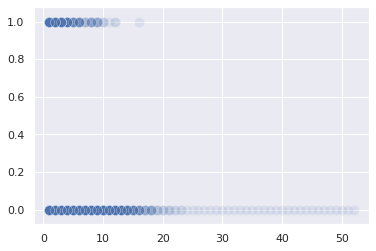

In [184]:
sns.scatterplot([x[0] for x in ordering_reg_data], [x[1] for x in ordering_reg_data], s=100, alpha=0.1)

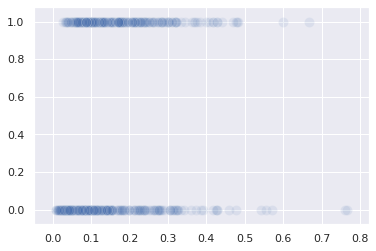

In [185]:
sns.scatterplot([x[0] for x in n_preds_data], [x[1] for x in n_preds_data], s=100, alpha=0.1)

# Generate Features for Part 3

In [186]:
if FLAGS.second_model == 'bert':
    tokenizer_2 = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
elif FLAGS.second_model == 'albert':
    tokenizer_2 = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.second_vocab_file)

eval_writer_2 = nqa_utils.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_2.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features_2 = []

def append_feature_2(feature):
    eval_features_2.append(feature)
    eval_writer_2.process_feature(feature)

# Limit examples to only those that are not unknown answers
eval_examples_2 = [example for example in remaining_examples if answers[example.example_id]['long_answer']]

for target_rank in range(8):
    # Get the document token index ranges of the desired answers
    pre_extra_tokens = 40
    post_extra_tokens = 15
    answer_ranges = []
    curr_examples = []
    for example in eval_examples_2:
        answer = answers[example.example_id]
        if target_rank >= len(answer['ordered_entries']):
            continue
        entry = answer['ordered_entries'][target_rank]

        doc_start_idx = entry['doc_tokens_start_idx']
        doc_end_idx = entry['doc_tokens_end_idx']

        answer_ranges.append((max(0, doc_start_idx - pre_extra_tokens),
                              min(len(example.doc_tokens), doc_end_idx + post_extra_tokens)))

        curr_examples.append(example)

    nqa_utils.convert_partial_examples_to_features(
        examples=eval_examples_2,
        ranges=answer_ranges,
        tokenizer=tokenizer_2,
        is_training=FLAGS.test_post_processing,
        output_fn=append_feature_2)

eval_writer_2.close()
eval_filename_2 = eval_writer_2.filename

print('# Remaining Examples (2):', len(eval_examples_2))
print('# Features (2):', len(eval_features_2))

# Remaining Examples (2): 531
# Features (2): 2510


# Build the Second Model and Run Predictions

In [187]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

In [188]:
n_steps = np.ceil(eval_writer_2.num_features / FLAGS.second_batch_size)
generator = nqa_utils.data_generator(eval_filename_2, FLAGS.second_batch_size)

preds_2 = model.predict(generator, steps=n_steps)

# Compute New Answers

In [310]:
# weights_2 = {
#     'ans_type_conf_weight': 0.1,
#     'start_pos_conf_weight': 0.45,
#     'end_pos_conf_weight': 0.45,
#     'conf_threshold': 0.988
# }


# weights_2 = {
#     'ans_type_conf_weight': 0.5,
#     'start_pos_conf_weight': 0.1,
#     'end_pos_conf_weight': 0.1,
#     'conf_threshold': 0.65
# }

weights_2 = {
    'ans_type_conf_weight': 0.4,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.2,
    'conf_threshold': 0.8
}

second_answers = nqa_utils.compute_answers(preds_2, 
                                           candidates_dict, 
                                           eval_features_2, 
                                           eval_examples_2, 
                                           id_to_example,
                                           weights=weights_2)

final_answers.update(second_answers)

if FLAGS.test_post_processing:
    print('ALBERT New Answers')
    print_scores(nqa_utils.score_preds(raw_examples, second_answers))
    print()
    print('Final Answer Answers')
    print_scores(nqa_utils.score_preds(raw_examples, final_answers))

ALBERT New Answers
Total Score 
 F1 = 0.646 | Recall = 0.533 | Precision = 0.820 | TP = 351 | FP = 308 | FN = 77 | TN = 326 

Long Answer Score 
 F1 = 0.651 | Recall = 0.538 | Precision = 0.824 | TP = 196 | FP = 168 | FN = 42 | TN = 125 

Short Answer Score 
 F1 = 0.639 | Recall = 0.525 | Precision = 0.816 | TP = 155 | FP = 140 | FN = 35 | TN = 201 


Final Answer Answers
Total Score 
 F1 = 0.650 | Recall = 0.523 | Precision = 0.857 | TP = 610 | FP = 556 | FN = 102 | TN = 732 

Long Answer Score 
 F1 = 0.660 | Recall = 0.533 | Precision = 0.865 | TP = 353 | FP = 309 | FN = 55 | TN = 283 

Short Answer Score 
 F1 = 0.636 | Recall = 0.510 | Precision = 0.845 | TP = 257 | FP = 247 | FN = 47 | TN = 449 



In [190]:
if FLAGS.test_post_processing:
    simple_answers = [{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} \
        for a in second_answers.values()]

    has_ans_perc = sum([1 for a in simple_answers if a['long_answer']]) / len(simple_answers)
    print('Has answer percent: {:.2f}%'.format(has_ans_perc * 100))

    n_la = 0
    n_sa = 0
    n_la_matches = 0
    n_sa_matches = 0
    for example_id in second_answers.keys():
        answer1 = answers[example_id]
        answer2 = second_answers[example_id]
        if answer2['long_answer']:
            n_la += 1
            if answer1['long_answer'] == answer2['long_answer']:
                n_la_matches += 1

        if answer2['short_answer']:
            n_sa += 1
            if answer1['short_answer'] == answer2['short_answer']:
                n_sa_matches += 1

    print('Long answer agreement: {:.2f}%'.format(n_la_matches/n_la * 100))
    print('Short answer agreement: {:.2f}%'.format(n_sa_matches/n_sa * 100))

Has answer percent: 74.43%
Long answer agreement: 84.10%
Short answer agreement: 64.97%


In [191]:
[{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} for a in final_answers.values()]

[{'long_answer': None, 'short_answer': None},
 {'long_answer': (88, 161), 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (138, 214), 'short_answer': (139, 145)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (67, 215), 'short_answer': (68, 71)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (232, 311), 'short_answer': None},
 {'long_answer': (101, 156), 'short_answer': (108, 109)},
 {'long_answer': (111, 222), 'short_answer': (133, 136)},
 {'long_answer': (233, 307), 'short_answer': (258, 260)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (143, 189), 'short_answer': (155, 164)},
 {'long_answer': (18, 71), 'short_answer': (30, 33)},
 {'long_answer': (18, 62), 'short_answer': None},
 {'long_answer': (218, 322), 'short_answer': None},
 {'long_answer': (244, 301), 'short_answer': (267, 279)},
 {'long_answer': (169, 303), 'short_answer': (229, 242)},
 {'l

# Grid Search for Postprocessing Parameters

In [266]:
if True:
    weight_ranges = collections.OrderedDict({
            'ans_type_conf_weight': [0.1, 1.5, 0.2, 2.5, 0.3, 3.5, 0.4, 4.5, 0.5],
            'start_pos_conf_weight': [0.1, 1.5, 0.2, 2.5, 0.3, 0.35, 0.4],
            'end_pos_conf_weight': [0.1, 1.5, 0.2, 2.5, 0.3, 0.35, 0.4],
            'conf_threshold': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
        })

    results = grid_search_weights(raw_examples,
                                  preds_2,
                                  candidates_dict, 
                                  eval_features_2, 
                                  eval_examples_2, 
                                  id_to_example,
                                  weight_ranges)
    
    for result in results[:10]:
        print(result)



  0%|          | 0/3969 [00:00<?, ?it/s]

  0%|          | 1/3969 [00:00<24:05,  2.74it/s]

  0%|          | 19/3969 [00:00<17:15,  3.82it/s]

  1%|          | 21/3969 [00:01<19:35,  3.36it/s]

  1%|          | 37/3969 [00:01<14:09,  4.63it/s]

  1%|          | 39/3969 [00:02<17:46,  3.68it/s]

  1%|          | 41/3969 [00:03<20:06,  3.26it/s]

  1%|          | 46/3969 [00:04<15:58,  4.09it/s]

  1%|          | 48/3969 [00:04<20:34,  3.18it/s]

  1%|          | 49/3969 [00:05<24:55,  2.62it/s]

  1%|▏         | 50/3969 [00:06<27:46,  2.35it/s]

  1%|▏         | 51/3969 [00:06<26:50,  2.43it/s]

  1%|▏         | 56/3969 [00:06<20:44,  3.14it/s]

  1%|▏         | 57/3969 [00:07<24:47,  2.63it/s]

  1%|▏         | 58/3969 [00:08<28:34,  2.28it/s]

  1%|▏         | 59/3969 [00:08<29:53,  2.18it/s]

  2%|▏         | 60/3969 [00:09<32:54,  1.98it/s]

  2%|▏         | 61/3969 [00:09<33:54,  1.92it/s]

  8%|▊         | 335/3969 [00:57<18:47,  3.22it/s]

  3%|▎         | 132/3969 [00:11<19:49

 27%|██▋       | 1066/3969 [01:27<16:33,  2.92it/s]

 27%|██▋       | 1067/3969 [01:28<17:27,  2.77it/s]

 27%|██▋       | 1068/3969 [01:28<18:15,  2.65it/s]

 27%|██▋       | 1069/3969 [01:28<18:52,  2.56it/s]

 27%|██▋       | 1070/3969 [01:29<19:15,  2.51it/s]

 27%|██▋       | 1071/3969 [01:29<19:27,  2.48it/s]

 29%|██▊       | 1135/3969 [01:30<13:24,  3.52it/s]

 29%|██▊       | 1140/3969 [01:32<15:02,  3.13it/s]

 29%|██▉       | 1144/3969 [01:32<11:54,  3.95it/s]

 29%|██▉       | 1154/3969 [01:32<08:53,  5.28it/s]

 29%|██▉       | 1157/3969 [01:34<11:51,  3.95it/s]

 29%|██▉       | 1159/3969 [01:35<14:05,  3.33it/s]

 29%|██▉       | 1161/3969 [01:35<15:18,  3.06it/s]

 30%|██▉       | 1173/3969 [01:36<11:09,  4.18it/s]

 30%|██▉       | 1175/3969 [01:37<13:30,  3.45it/s]

 30%|██▉       | 1177/3969 [01:37<15:13,  3.06it/s]

 30%|██▉       | 1178/3969 [01:38<16:27,  2.83it/s]

 30%|██▉       | 1179/3969 [01:39<25:42,  1.81it/s]

 30%|██▉       | 1183/3969 [01:39<19:25,  2.39

 53%|█████▎    | 2105/3969 [02:55<11:45,  2.64it/s]

 53%|█████▎    | 2106/3969 [02:55<12:16,  2.53it/s]

 53%|█████▎    | 2120/3969 [02:56<08:48,  3.50it/s]

 53%|█████▎    | 2122/3969 [02:56<10:01,  3.07it/s]

 53%|█████▎    | 2123/3969 [02:57<10:54,  2.82it/s]

 54%|█████▎    | 2124/3969 [02:57<11:23,  2.70it/s]

 54%|█████▎    | 2129/3969 [02:58<08:43,  3.52it/s]

 54%|█████▎    | 2130/3969 [02:58<09:56,  3.08it/s]

 54%|█████▎    | 2131/3969 [02:58<10:43,  2.86it/s]

 54%|█████▎    | 2132/3969 [02:59<11:18,  2.71it/s]

 54%|█████▎    | 2133/3969 [02:59<11:42,  2.61it/s]

 54%|█████▍    | 2139/3969 [03:00<08:48,  3.46it/s]

 54%|█████▍    | 2140/3969 [03:00<10:12,  2.98it/s]

 54%|█████▍    | 2141/3969 [03:01<10:58,  2.78it/s]

 54%|█████▍    | 2142/3969 [03:01<11:37,  2.62it/s]

 54%|█████▍    | 2145/3969 [03:01<09:23,  3.24it/s]

 54%|█████▍    | 2146/3969 [03:02<10:36,  2.86it/s]

 54%|█████▍    | 2147/3969 [03:02<11:34,  2.62it/s]

 54%|█████▍    | 2148/3969 [03:03<11:57,  2.54

 97%|█████████▋| 3867/3969 [04:43<00:25,  3.94it/s]

 97%|█████████▋| 3869/3969 [04:44<00:35,  2.85it/s]

 98%|█████████▊| 3870/3969 [04:45<00:38,  2.58it/s]

 98%|█████████▊| 3886/3969 [04:45<00:23,  3.56it/s]

 98%|█████████▊| 3888/3969 [04:46<00:28,  2.85it/s]

 98%|█████████▊| 3895/3969 [04:47<00:20,  3.69it/s]

 98%|█████████▊| 3897/3969 [04:48<00:26,  2.73it/s]

 98%|█████████▊| 3905/3969 [04:48<00:17,  3.58it/s]

 98%|█████████▊| 3906/3969 [04:49<00:21,  2.91it/s]

 99%|█████████▊| 3911/3969 [04:49<00:15,  3.70it/s]

 99%|█████████▊| 3912/3969 [04:50<00:18,  3.16it/s]

 99%|█████████▊| 3913/3969 [04:50<00:20,  2.67it/s]

 99%|█████████▊| 3914/3969 [04:51<00:22,  2.44it/s]

 99%|█████████▊| 3915/3969 [04:51<00:22,  2.35it/s]

 99%|█████████▉| 3930/3969 [04:52<00:12,  3.22it/s]

 99%|█████████▉| 3931/3969 [04:53<00:15,  2.43it/s]

 99%|█████████▉| 3932/3969 [04:53<00:18,  2.01it/s]

 99%|█████████▉| 3933/3969 [04:54<00:18,  1.94it/s]

 99%|█████████▉| 3949/3969 [04:55<00:07,  2.69

((0.5, 0.1, 0.1, 0.65), 0.6458141674333027)
((0.4, 0.1, 0.1, 0.55), 0.6451033243486074)
((0.4, 0.1, 0.2, 0.65), 0.6426642664266426)
((0.4, 0.2, 0.1, 0.65), 0.6426642664266426)
((0.2, 0.2, 0.1, 0.45), 0.6373239436619719)
((0.2, 0.2, 0.2, 0.55), 0.6373239436619719)
((0.2, 0.2, 0.3, 0.65), 0.6373239436619719)
((0.4, 0.3, 0.1, 0.7), 0.6373239436619719)
((0.1, 0.3, 0.4, 0.4), 0.6369982547993019)
((0.1, 0.3, 0.4, 0.45), 0.6369982547993019)


### BERT Joint Baseline (200 examples)
    - F1: 0.564
    - Recall: 0.850
    - Precision: 0.422
    
    On 2000 dev examples:
    - F1: 0.524
    
### BERT Joint + ALBERT Finetuned (200 examples)
    - F1: 0.628
    - Recall: 0.667
    - Precision: 0.593
    
    On 2000 dev examples:
    
    'ans_type_conf_weight': 0.6,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.1,
    'conf_threshold': 0.8
        
    - F1: 0.613
    
### ALBERT Small Examples + BERT Joint + ALBERT Finetuned (2000 examples)
    - F1: 0.645
    - Recall: 0.582
    - Precision: 0.723
    
### ALBERT Finetuned (200 examples)
    - F1: 0.791
    - Recall: 0.895
    - Precision: 0.708

## Function to Create a Submission

In [12]:
def create_submission(answers):
    submission_data = []

    # Loop through answers in alphabetic order of example_ids
    # This is how it's sorted in the sample submission
    for example_id, answer in sorted(answers.items(), key=lambda x: x[0]):
        long_answer_text = ''
        if isinstance(answer['long_answer'], tuple):
            long_answer_text = f'{answer["long_answer"][0]}:{answer["long_answer"][1]}'
        else:
            assert answer['long_answer'] is None, 'Invalid type of long answer!'
            assert answer['short_answer'] is None, 'Cannot have a short answer with no long answer!'
        long_answer_row = [f'{example_id}_long', long_answer_text]

        short_answer_text = ''
        if isinstance(answer['short_answer'], tuple):
            short_answer_text = f'{answer["short_answer"][0]}:{answer["short_answer"][1]}'
        elif answer['short_answer'] in ('YES', 'NO'):
            short_answer_text = answer['short_answer']
        else:
            assert answer['short_answer'] is None, 'Invalid type of short answer!'
        short_answer_row = [f'{example_id}_short', short_answer_text]

        submission_data.append(long_answer_row)
        submission_data.append(short_answer_row)

    submission_df = pd.DataFrame(submission_data, columns=['example_id', 'PredictionString'])
    return submission_df

# Create and Save the Submission!

In [14]:
if not FLAGS.test_post_processing:
    submission_df = create_submission(final_answers)
    print(submission_df.head())
    submission_df.to_csv('submission.csv', index=False)

                   example_id PredictionString
0   -9198586108074363474_long        1854:2771
1  -9198586108074363474_short        2573:2576
2   -9106782542406690435_long          452:667
3  -9106782542406690435_short          561:563
4   -9076824655968712429_long        3188:3332


In [15]:
with open('submission.csv', 'r') as f:
    a = f.read()
print(a)

example_id,PredictionString
-9198586108074363474_long,1854:2771
-9198586108074363474_short,2573:2576
-9106782542406690435_long,452:667
-9106782542406690435_short,561:563
-9076824655968712429_long,3188:3332
-9076824655968712429_short,
-9030298026304897796_long,2738:2908
-9030298026304897796_short,
-9017879887869944707_long,1054:1285
-9017879887869944707_short,
-8908130259426804995_long,739:834
-8908130259426804995_short,
-8752372642178983917_long,
-8752372642178983917_short,
-8724786492706035378_long,374:474
-8724786492706035378_short,405:417
-8526204458464385509_long,
-8526204458464385509_short,
-8260765274544672220_long,
-8260765274544672220_short,
-8232502904250181946_long,1255:1373
-8232502904250181946_short,1276:1282
-8208740459851986084_long,383:499
-8208740459851986084_short,487:488
-8161758226997940269_long,
-8161758226997940269_short,
-8153331489994186161_long,1030:1245
-8153331489994186161_short,
-8116975568046358937_long,
-8116975568046358937_short,
-8080840187735702908_long,